In [115]:
import pystac
from pystac_client import Client
from shapely.geometry import Point
import rioxarray
import numpy as np
import earthpy.plot as ep
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from xrspatial import zonal_stats
import xarray as xr
import geopandas as gpd
import rasterio

In [105]:
api_url = "https://earth-search.aws.element84.com/v0"
client = Client.open(api_url)
collection = "sentinel-s2-l2a-cogs"  # Sentinel-2, Level 2A, COGs
point = Point(4.89, 52.37)  # AMS coordinates

In [106]:
search = client.search(
    collections=[collection],
    intersects=point,
    max_items=10,
)

In [107]:
items = search.get_all_items()

In [129]:
bbox = point.buffer(0.01).bounds

search = client.search(
    collections=[collection],
    bbox=bbox,
    datetime="2020-03-20/2020-03-30",
    query=["eo:cloud_cover<10"]
)
print(search.matched())

4


In [130]:
items = search.get_all_items()
items.save_object("search.json")

In [131]:
items = pystac.ItemCollection.from_file("search.json")

red_uri = items[1].assets["B04"].href
nir_uri = items[1].assets["B8A"].href

red = rioxarray.open_rasterio(red_uri, masked=True)
nir = rioxarray.open_rasterio(nir_uri, masked=True)


In [132]:
bbox = (629000, 5804000, 639000, 5814000)
red_clip = red.rio.clip_box(*bbox)
nir_clip = nir.rio.clip_box(*bbox)

In [133]:
red_clip_matched = red_clip.rio.reproject_match(nir_clip)
print(red_clip_matched.shape)

(1, 500, 500)


In [134]:
red_clip_matched = red_clip.rio.reproject_match(nir_clip)
print(red_clip_matched.shape)

(1, 500, 500)


<xarray.DataArray (band: 1, y: 1, x: 1)>
array([[[nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.321e+05
  * y            (y) float64 5.805e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

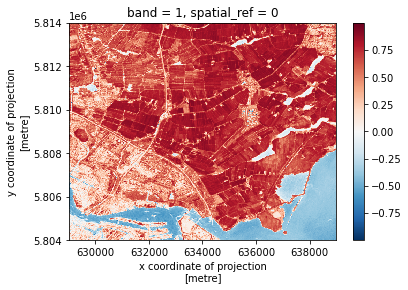

In [135]:
ndvi = (nir_clip - red_clip_matched)/ (nir_clip + red_clip_matched)
ndvi.plot()
nir_clip.isnull()
nir_clip.where(nir_clip.isnull(), drop=True)

In [20]:
red
print(ndvi.rio.crs)

EPSG:32631


In [21]:
from pyproj import CRS
epsg = ndvi.rio.crs.to_epsg()
crs = CRS(epsg)
crs

<Derived Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.
- bounds: (0.0, 0.0, 6.0, 84.0)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
crs.area_of_use

AreaOfUse(west=0.0, south=0.0, east=6.0, north=84.0, name='Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.')

In [81]:
ndvi.isnull()
ndvi.where(ndvi.isnull(), drop=True)

<xarray.DataArray (band: 1, y: 1, x: 1)>
array([[[nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.321e+05
  * y            (y) float64 5.805e+06
    spatial_ref  int64 0

In [78]:
ndvi

<xarray.DataArray (band: 1, y: 500, x: 500)>
array([[[ 0.7379576 ,  0.77153456,  0.54531944, ...,  0.39254385,
          0.49227372,  0.4465174 ],
        [ 0.7024894 ,  0.7074668 ,  0.3903298 , ...,  0.423283  ,
          0.4706971 ,  0.45964912],
        [ 0.6557818 ,  0.5610572 ,  0.46742022, ...,  0.4510345 ,
          0.43815723,  0.6005133 ],
        ...,
        [ 0.02391171,  0.21843003,  0.02479339, ..., -0.50923485,
         -0.53367877, -0.4955414 ],
        [ 0.11376493,  0.17681159, -0.1673566 , ..., -0.5221932 ,
         -0.5271318 , -0.4852753 ],
        [ 0.45398772, -0.00518135,  0.03346133, ..., -0.5019455 ,
         -0.4987013 , -0.49081364]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.29e+05 6.29e+05 6.29e+05 ... 6.39e+05 6.39e+05
  * y            (y) float64 5.814e+06 5.814e+06 ... 5.804e+06 5.804e+06
    spatial_ref  int64 0

In [66]:
# Defines the bins for pixel values
class_bins = (-1, 0., 0.2, 0.7, 1)

# The numpy.digitize function returns an unlabeled array, in this case, a
# classified array without any metadata. That doesn't work--we need the
# coordinates and other spatial metadata. We can get around this using
# xarray.apply_ufunc, which can run the function across the data array while
# preserving metadata.
ndvi_classified = xr.apply_ufunc(
    np.digitize,
    ndvi,
    class_bins
)

np.unique(ndvi_classified)

array([1, 2, 3, 4, 5])

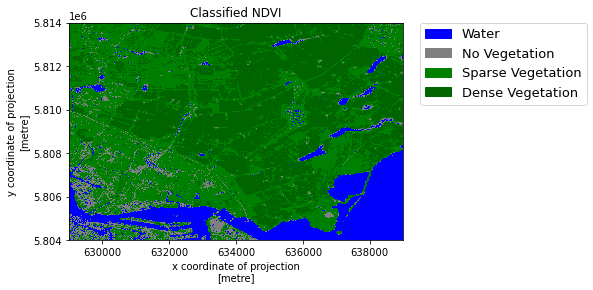

In [63]:
# Define color map of the map legend
ndvi_colors = ["blue", "gray", "green", "darkgreen"]
ndvi_cmap = ListedColormap(ndvi_colors)

# Define class names for the legend
category_names = [
    "Water",
    "No Vegetation",
    "Sparse Vegetation",
    "Dense Vegetation"
]

# We need to know in what order the legend items should be arranged
category_indices = list(range(len(category_names)))

# Make the plot
im = ndvi_classified.plot(cmap=ndvi_cmap, add_colorbar=False)
plt.title("Classified NDVI")
# earthpy helps us by drawing a legend given an existing image plot and legend items, plus indices
ep.draw_legend(im_ax=im, classes=category_indices, titles=category_names)


In [136]:
ndvi_b1 = ndvi.sel(band=1)
ndvi_classified_b1 = ndvi_classified.sel(band=1)

In [139]:
ndvi_sq = ndvi.squeeze()
ndvi_classified_sq = ndvi_classified.squeeze()

In [140]:
zonal_stats(ndvi_classified_sq,ndvi_sq)

,zone,mean,max,min,sum,std,var,count
0,1,-0.355667,-0.000257,-0.998648,-12838.162109,0.145911,0.021290,36096.0
1,2,0.110731,0.199839,0.000000,1754.752441,0.055864,0.003121,15847.0
2,3,0.507998,0.700000,0.200000,50410.171875,0.140193,0.019654,99233.0
3,4,0.798281,0.999579,0.700025,78888.523438,0.051730,0.002676,98823.0
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
ndvi.rio.crs

CRS.from_epsg(32631)

In [82]:
ndvi_1 = ndvi.where(ndvi_classified==1)
ndvi_2 = ndvi.where(ndvi_classified==2)
ndvi_3 = ndvi.where(ndvi_classified==3)
ndvi_4 = ndvi.where(ndvi_classified==4)

(array([2.315e+03, 2.402e+03, 2.384e+03, 2.527e+03, 2.519e+03, 2.613e+03,
        2.780e+03, 2.799e+03, 2.948e+03, 2.931e+03, 3.168e+03, 3.281e+03,
        3.372e+03, 3.451e+03, 3.499e+03, 3.604e+03, 3.710e+03, 3.672e+03,
        3.783e+03, 3.801e+03, 3.996e+03, 3.809e+03, 3.878e+03, 3.761e+03,
        3.575e+03, 3.325e+03, 3.102e+03, 2.594e+03, 2.312e+03, 1.942e+03,
        1.596e+03, 1.258e+03, 9.350e+02, 5.880e+02, 3.520e+02, 1.830e+02,
        5.400e+01, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([0.7000253 , 0.70601636, 0.71200746, 0.7179985 , 0.7239896 ,
        0.72998065, 0.73597175, 0.7419628 , 0.7479539 , 0.75394493,
        0.75993603, 0.7659271 , 0.7719182 , 0.7779092 , 0.78390026,
        0.78989136, 0.7958824 , 0.8018735 , 0.80786455, 0.81385565,
        0.8198467 , 0.8258378 , 0.83182883, 0.83781993, 0.843811  ,
        0.849802  , 0.8557931 , 0.86

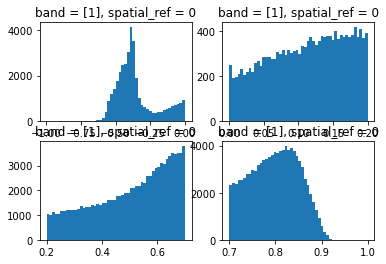

In [94]:
plt.subplot(2,2,1)
ndvi_1.plot.hist(bins=50)
plt.subplot(2,2,2)
ndvi_2.plot.hist(bins=50)
plt.subplot(2,2,3)
ndvi_3.plot.hist(bins=50)
plt.subplot(2,2,4)
ndvi_4.plot.hist(bins=50)

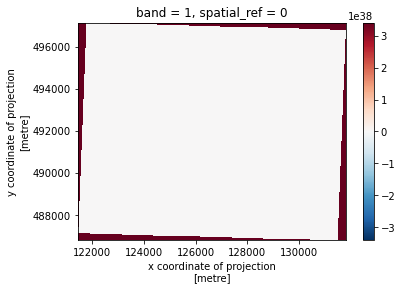

In [98]:
from rasterio.enums import Resampling

ndvi_reproject = ndvi.rio.reproject(28992,resampling=Resampling.nearest)
ndvi_reproject.plot()

/home/pchandramouli/anaconda3/envs/geospatial/lib/python3.9/site-packages/matplotlib/colors.py:1253: RuntimeWarning: overflow encountered in subtract
  resdat -= vmin


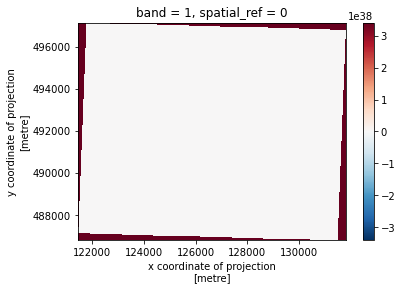